# Проект "Банки — Анализ оттока клиентов"

## Описание проекта

Перед нам стоит ряд задач:
- Провести исследовательский анализ данных банка,
- Выделить портреты клиентов, которые склонны уходить из банка,
- Сформулировать и проверить статистические гипотезы.

### Загрузка данных и изучение общей информации

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import math
import warnings
import phik
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

In [4]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


## Предобработка данных
Произведем предобработку данных.
### Замена названий столбцов (приведем к нижнему регистру)

In [6]:
data.columns = data.columns.str.lower()

### Проверка типов данных
Скорретируем типы данных у некоторых столбцов

In [7]:
data['score'] = data['score'].astype('Int64')
data['age'] = data['age'].astype('Int64')


### Работа с пропусками

In [8]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16)
            .set_title('Доля пропущенных значений в столбцах, %' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

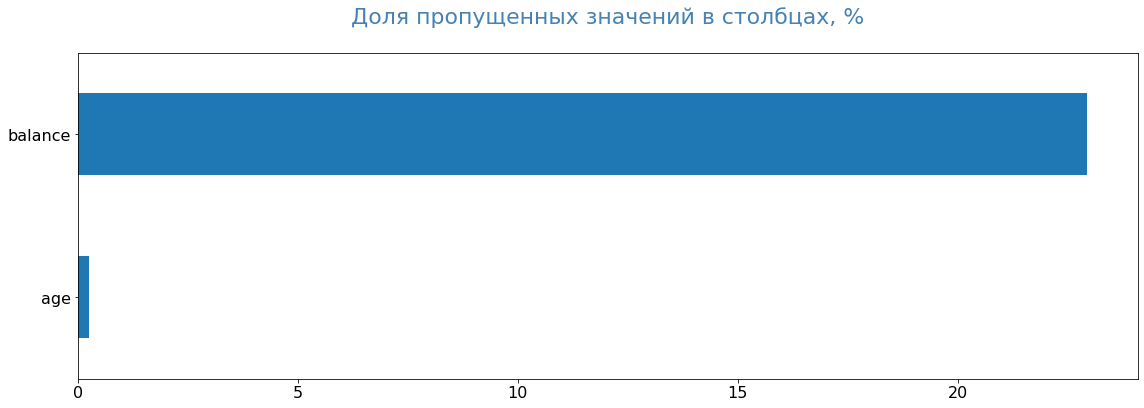

In [9]:
pass_value_barh(data)

Пропуски присутсвуют в двух столбцах: Баланс и Возвраст. Пропущенных данных в столбце возраст не так много (<1%), восполнять такой показатель как возраст средними и медианным значениям неэффективно, отбросим строки, где значение возраста пропущено.

In [10]:
data.dropna(subset = ['age'], inplace = True)

Необходимо исследовать пропуски в графе баланса:

In [11]:
data['balance_is_na'] = data['balance'].isna()

In [12]:
data.head(5)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_is_na
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,False
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,False
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,True
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,False
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,False


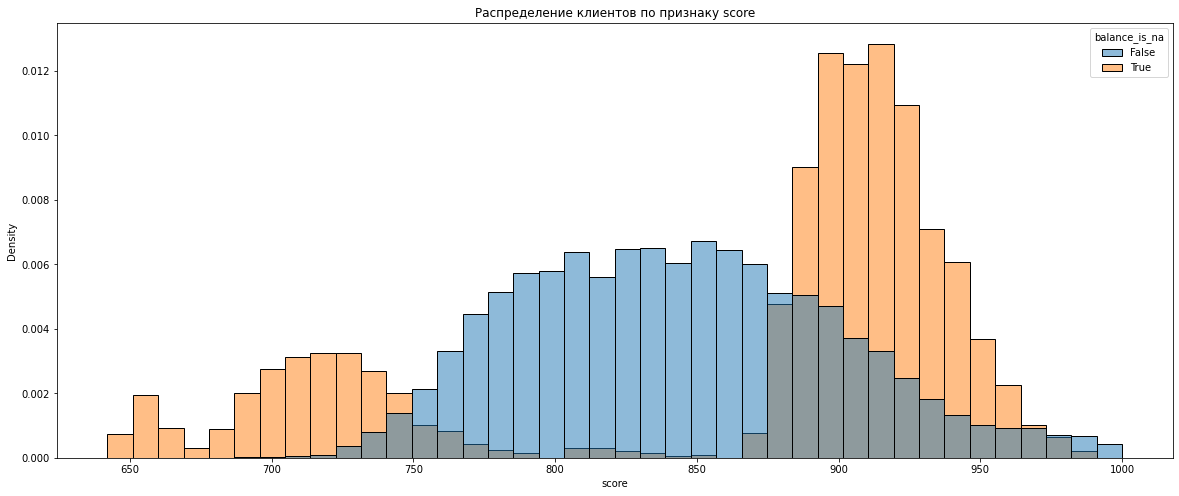

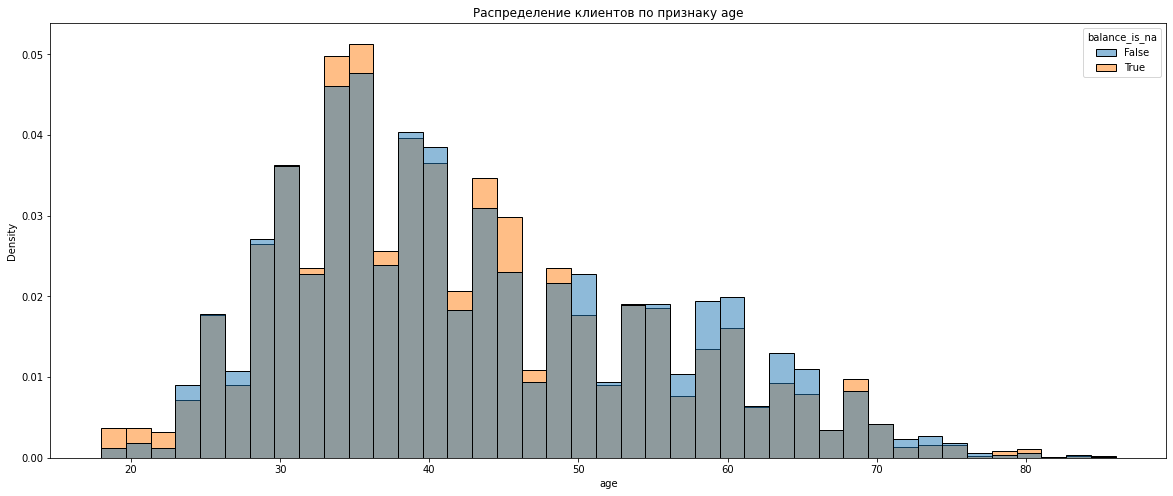

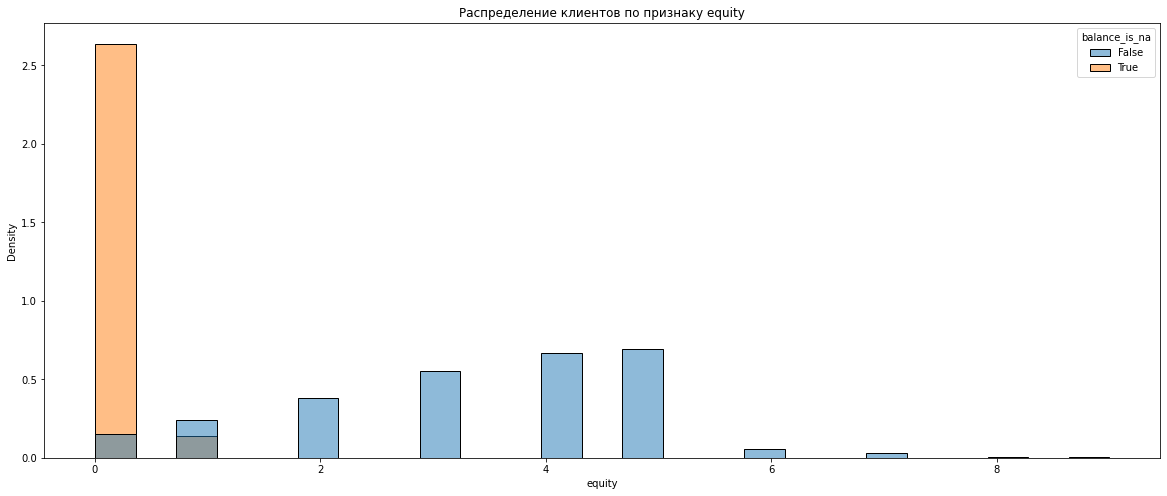

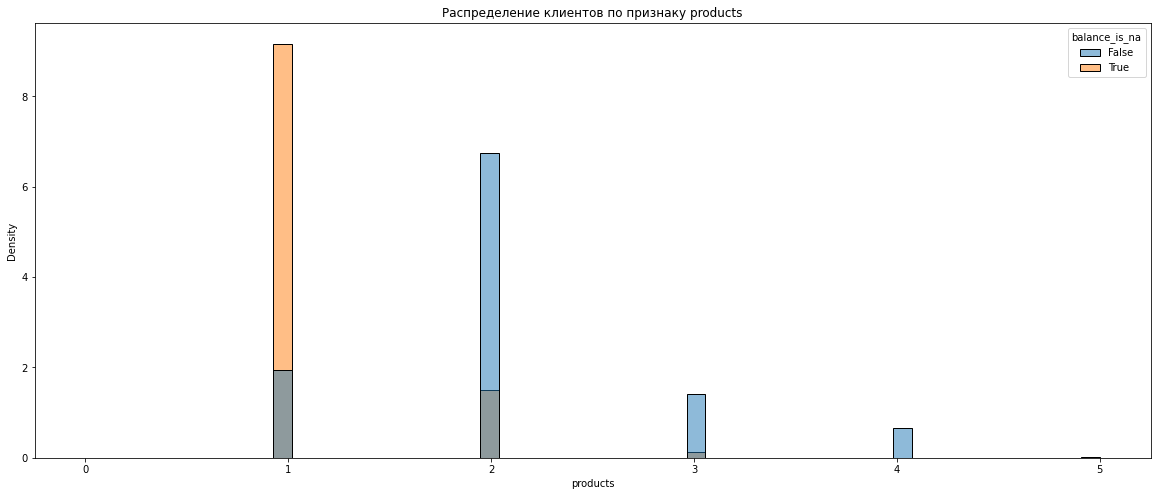

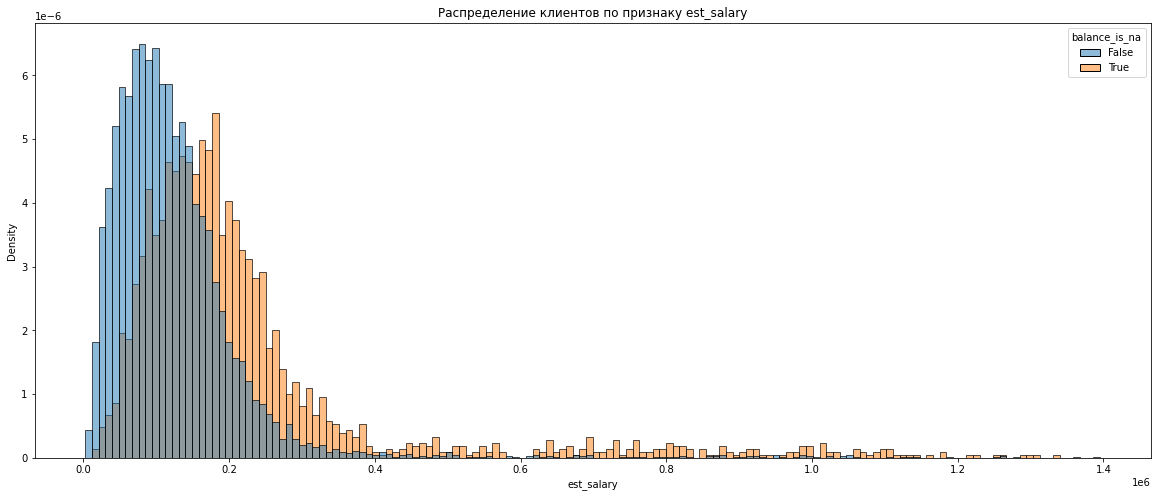

In [13]:
for column in ['score', 'age', 'equity', 'products', 'est_salary']:
    plt.figure(figsize=(20,8))
    sns.histplot(data=data, x=column, hue='balance_is_na', stat="density", common_norm=False);
    plt.title(f'Распределение клиентов по признаку {column}')
    plt.show()   

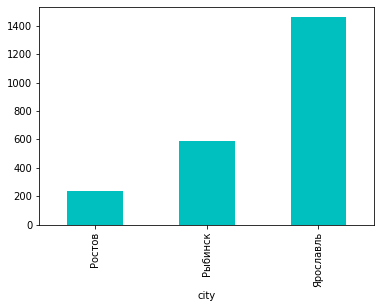

In [14]:
city_group = data.query('balance_is_na == True').groupby('city')['userid'].count()
city_group.plot(kind='bar', color='c');

- Нет данных о балансе у клиентов с самыми низкими и самыми высокими оценками скоринга.
- Распределение данных о возрасте почти одинаковое для данных с пропусками и данных без пропусков.
- Нет данных о балансе у клиентов, у которых нет собственности или один объект, а также один или два продукта банка 
- Распределение по доходам схожи, хотя для среза данных с пропусками немного смещены.
- Больше всего пропусков для клиентов из Ярославля (но пользователей из Ярославля и так больше)

In [15]:
# сделаем срез данных, где баланс пропущен, и сравним средние значения баланса
nan_balance = data.query('balance.isna()')

print('Средние значения признаков всего датафрейма')
print(round(data.mean(), 2))
print('------------------------------')
print('Средние значения признаков датафрейма с пропусками в столбце balance')
print(round(nan_balance.mean(), 2))

Средние значения признаков всего датафрейма
userid           171755.22
score               848.68
age                  42.73
equity                2.63
balance          827245.59
products              1.87
credit_card           0.68
last_activity         0.52
est_salary       147786.81
churn                 0.18
balance_is_na         0.23
dtype: float64
------------------------------
Средние значения признаков датафрейма с пропусками в столбце balance
userid           171904.89
score               865.36
age                  42.09
equity                0.05
balance                NaN
products              1.16
credit_card           0.82
last_activity         0.55
est_salary       226345.42
churn                 0.01
balance_is_na         1.00
dtype: float64


- Средние значения большинства признаков схожи, нет связи пропусков с остальными данными. Следовательно пропуски не связаны с оттоком (они есть как у тех, кто является клиентом, так и у тех, кто рассторгнул договор). <br>

Можно предположить, что пропуски значений - это счета без средств, тогда можно заменить пропущенные значения на ноль.

In [16]:
data = data.drop(['balance_is_na'], axis=1)

### Обработка дубликатов

In [17]:
data.duplicated().sum()

0

In [18]:
data.duplicated(subset=['gender','age', 'est_salary']).sum()

0

Полностью совпадающих строк нет.

In [19]:
data['userid'].duplicated().sum()

50

Но есть дубликаты АйДи пользователя. Удалим эти строки.

In [20]:
data = data.drop_duplicates(['userid']).reset_index(drop = True)

### Добавление столбцов для численного кодирования данных (пол и город)
#### Кодируем столбец "Gender"
Код: 1 - Женский, 0 - Мужской

In [21]:
data['dender_kod'] =  np.where(data['gender']== 'Ж', 1, 0)

#### Кодируем столбец "City"

In [22]:
data['city_1']=data['city']
data = pd.get_dummies(data, columns=["city_1"], prefix=["city"])

In [23]:
data.head(8)

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,dender_kod,city_Ростов,city_Рыбинск,city_Ярославль
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,1,0,1,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,1,0,1,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,1,0,1,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,1,0,0,1
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0,0,1
5,202305,856,Рыбинск,М,56,4,863687.24,3,1,0,156619.80,0,0,0,1,0
6,177259,807,Ярославль,Ж,39,3,405042.44,3,0,1,103838.32,0,1,0,0,1
7,218868,825,Ярославль,Ж,38,4,458145.40,2,1,1,68085.48,0,1,0,0,1


#### Исследования аномальных значений

In [25]:
print('Данные по собственности:')
print(data['equity'].value_counts())
print('------------------------------')
print('Данные по количеству продуктов:')
print(data['products'].value_counts())

Данные по собственности:
0    2554
5    1910
4    1841
3    1532
2    1046
1     771
6     161
7      79
8      17
9      13
Name: equity, dtype: int64
------------------------------
Данные по количеству продуктов:
2    5095
1    3306
3    1029
4     474
5      19
0       1
Name: products, dtype: int64


In [26]:
data['est_salary'].describe()

count    9.924000e+03
mean     1.478802e+05
std      1.393583e+05
min      2.546300e+03
25%      7.525218e+04
50%      1.197154e+05
75%      1.746669e+05
max      1.395064e+06
Name: est_salary, dtype: float64

In [27]:
data['balance'].describe()

count    7.664000e+03
mean     8.282063e+05
std      1.984122e+06
min      0.000000e+00
25%      2.955266e+05
50%      5.249277e+05
75%      9.807537e+05
max      1.191136e+08
Name: balance, dtype: float64

Среди рассмотренных столбцов, аномальное значение обнаружено в столбце количества продуктов, у одного из клиентов нет ни одного продукта. Удалим эту строку.

In [28]:
data = data.query('products != 0')

## Исследовательский анализ данных

### Изучение средних значений и общего портрета клиента

In [29]:
data.describe()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,dender_kod,city_Ростов,city_Рыбинск,city_Ярославль
count,9923.000000,9923.000000,9923.000000,9923.000000,7.664000e+03,9923.000000,9923.000000,9923.000000,9.923000e+03,9923.000000,9923.000000,9923.000000,9923.000000,9923.000000
mean,171739.567268,848.719944,42.725184,2.634486,8.282063e+05,1.871813,0.680036,0.523430,1.478926e+05,0.183211,0.499043,0.142699,0.267359,0.589943
std,33698.263769,65.390298,12.171619,1.979467,1.984122e+06,0.792969,0.466486,0.499476,1.393599e+05,0.386859,0.500024,0.349783,0.442603,0.491869
min,94561.000000,642.000000,18.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,2.546300e+03,0.000000,0.000000,0.000000,0.000000,0.000000
25%,142720.000000,802.000000,33.000000,0.000000,2.955266e+05,1.000000,0.000000,0.000000,7.525586e+04,0.000000,0.000000,0.000000,0.000000,0.000000
50%,172651.000000,853.000000,40.000000,3.000000,5.249277e+05,2.000000,1.000000,1.000000,1.197193e+05,0.000000,0.000000,0.000000,0.000000,1.000000
75%,201160.500000,900.000000,51.000000,4.000000,9.807537e+05,2.000000,1.000000,1.000000,1.746733e+05,0.000000,1.000000,0.000000,1.000000,1.000000
max,229145.000000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000,1.000000,1.000000,1.000000,1.000000


Исходя из данных можно составить следующий портрет среднестатистического клиента:
- В среднем клиенту почти 43 года, его скоринговая оценка - около 850 баллов. Средний доход около 100 тыс.
- У среднестатистического клиента около трех объектов собственности и он пользуется двумя продуктами банка. 
- Кроме того, важно отметить: среди клиентов мужчин и женщин примерно поровну.
- Более двух третей клиентов пользуются кредитными картами.
- Больше всего клиентов банка находится в Ярославле.


**Отток клиентов - 18%.** <br>

,churn
churn,
0,8105
1,1818


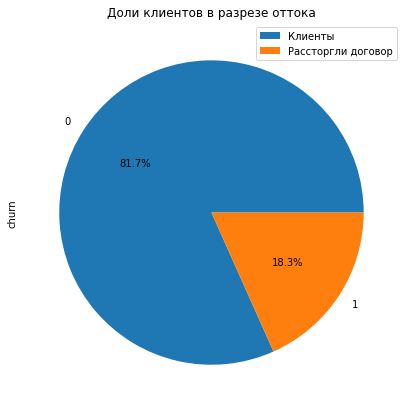

In [30]:
churn_perc = data.groupby('churn').agg({'churn': 'count'})
display(churn_perc)

churn_perc.plot(kind='pie', y='churn', autopct='%1.1f%%', figsize=(7,7))
plt.title('Доли клиентов в разрезе оттока')
plt.legend(['Клиенты', 'Рассторгли договор'])
plt.show()

Изучим средние показателеи в разрезе оттока.

In [31]:
data.groupby('churn').mean()

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,dender_kod,city_Ростов,city_Рыбинск,city_Ярославль
churn,,,,,,,,,,,,,
0,171907.064035,845.435657,43.015793,2.381246,7.337899e+05,1.758421,0.708822,0.483282,147788.268353,0.532634,0.142011,0.273535,0.584454
1,170992.833883,863.361936,41.429593,3.763476,1.134458e+06,2.377338,0.551705,0.702420,148357.483157,0.349285,0.145765,0.239824,0.614411


In [32]:
quantitative = ['score', 'age', 'equity', 'balance', 'products', 'est_salary']
qualitative = ['credit_card', 'last_activity', 'dender_kod', 'churn', 'city_Ростов', 'city_Рыбинск', 'city_Ярославль']

In [33]:
# функция для формирования графиков распределения
# hue - признак, по которому мы хотим увидеть детализацию данных

def distr_charts(data, hue):
    # столбчатые диаграммы:
    for column in ['credit_card', 'last_activity', 'dender_kod', 'products',  'equity']:
        common_churn_level = data['churn'].mean() * 100
        columns_churn = data.groupby(column)['churn'].mean() * 100
        
        plt.figure(figsize=(8, 5))
        plt.axhline(y= common_churn_level, linewidth=2, linestyle='--', color='k')
        ax = columns_churn.plot(kind='bar', color='c')
        plt.xticks(rotation=0)
        plt.title(f'Процент оттока клиентов по категории {column} относительно среднего по банку')
        plt.show()

    # kde график:
    for column in ['score', 'equity', 'products']:
        plt.figure(figsize=(20,8))
        sns.histplot(data=data, x=column, hue=hue, stat="density", common_norm=False);
        plt.title(f'Распределение клиентов по признаку {column}')
        plt.show() 
        
        # kde графики для столбцов с длинными хвостами:

    plt.figure(figsize=(20,8))
    sns.histplot(data=data, x='est_salary', hue=hue, stat="density", common_norm=False);
    plt.title(f'Распределение клиентов по признаку est_salary')
    plt.xlim([0, 500000])
    plt.show() 
    

    plt.figure(figsize=(20,8))
    sns.histplot(data=data, x='balance', hue=hue, stat="density", common_norm=False);
    plt.title(f'Распределение клиентов по признаку balance')
    plt.xlim([0, 2500000])
    plt.show() 
    
    # столбец age, с целочисленными корзинами
    plt.figure(figsize=(20,8))
    sns.histplot(data=data, x='age', hue=hue, stat="density", common_norm=False, binwidth=1);
    plt.title('Распределение клиентов по признаку age')
    plt.show()

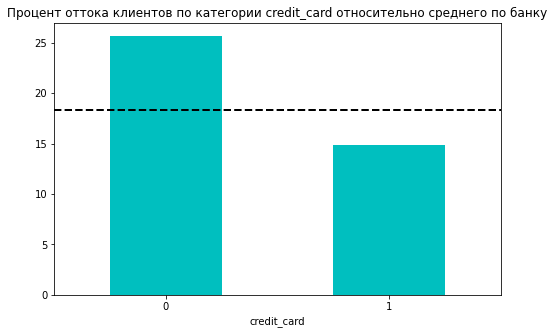

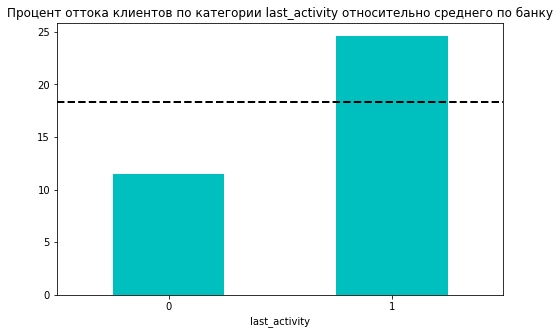

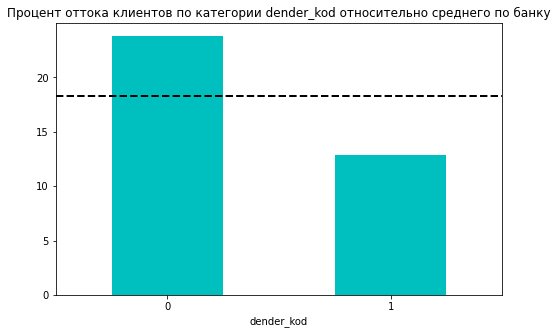

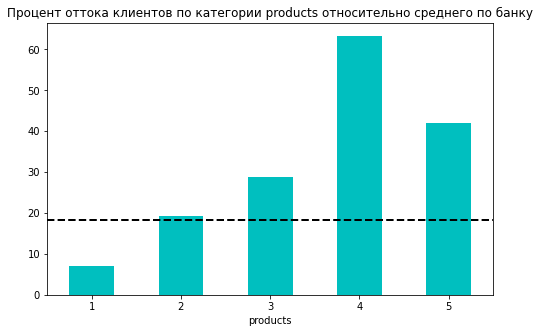

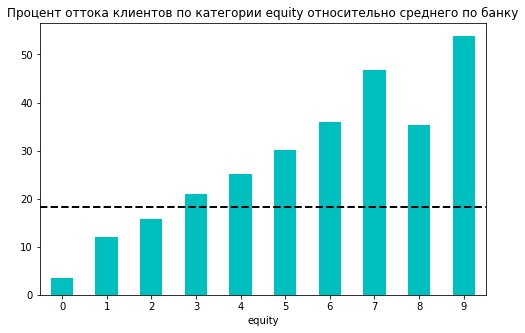

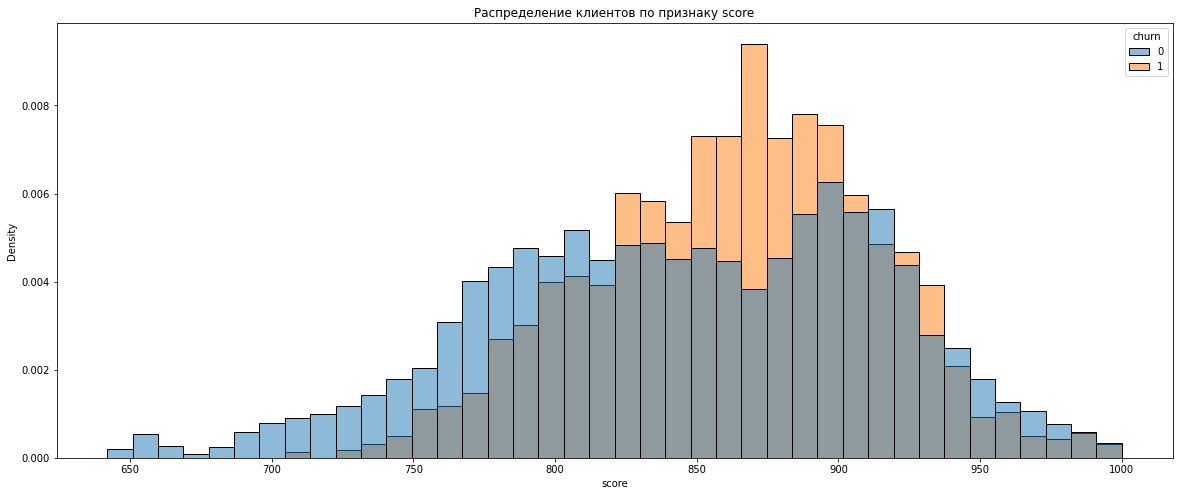

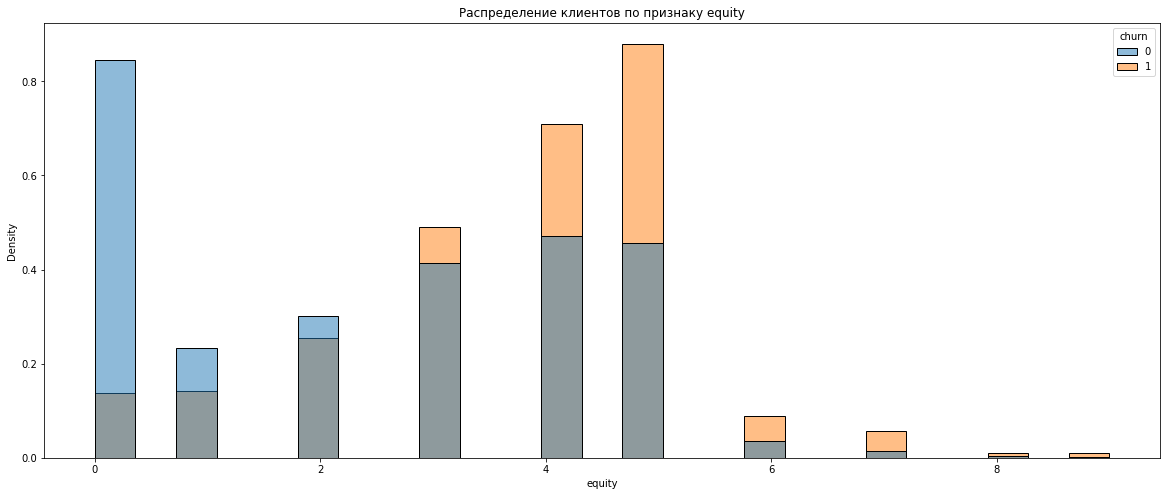

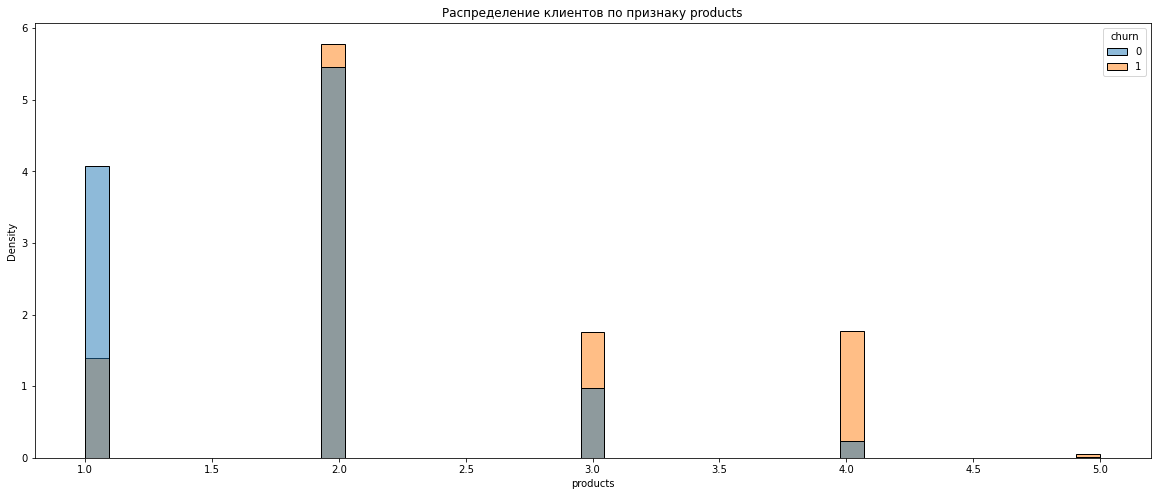

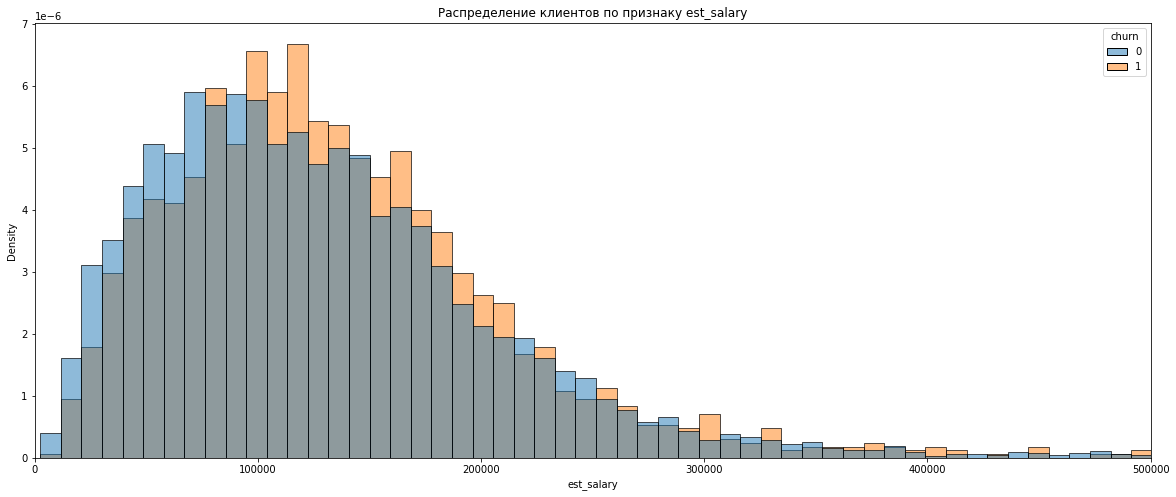

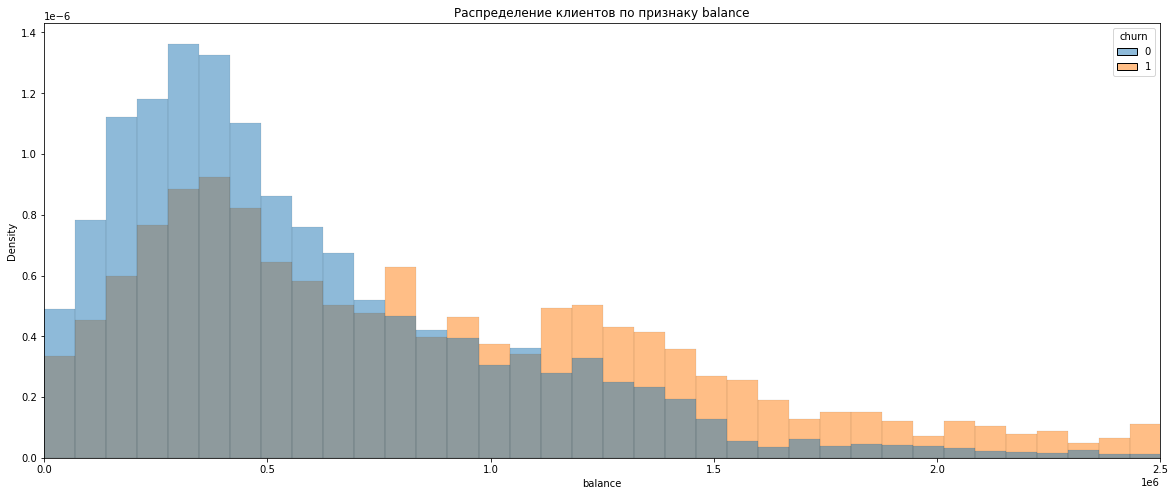

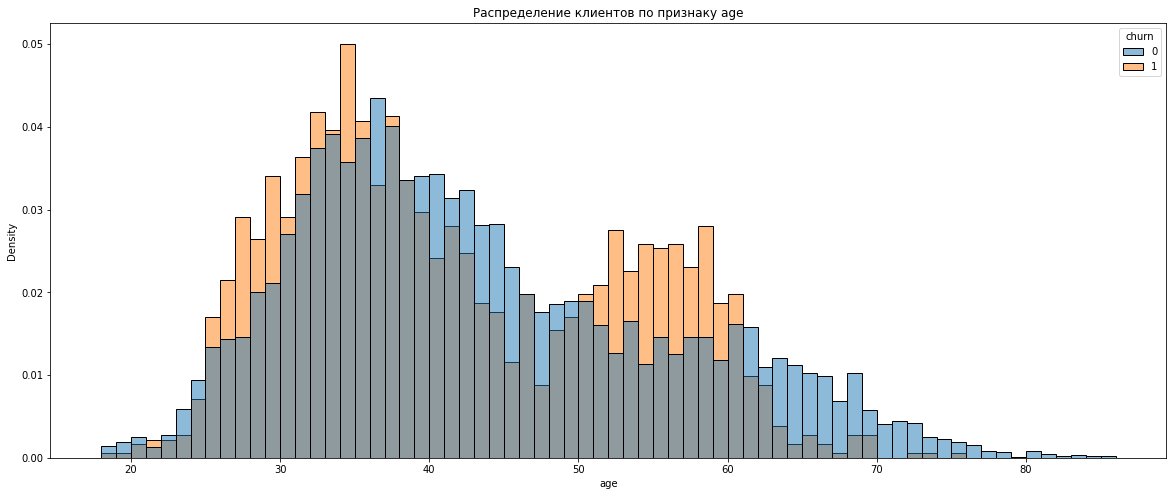

In [34]:
distr_charts(data, 'churn')

Средние показатели среди ушедших клиентов:<br>
- Скоринговая оценка 863 (выше, чем у среднего оставшегося клиента)
- Мужчина, 41 год, проживает в Ярославле
- Средний доход 148 тыс (выше, чем у среднешл оставшегося клиента)
- У клиента больше трех объектов недвижимости и несколько продуктов банка.


Кроме того, можно отметить:
- Среди клиентов, пользующихся кредитными картами, уровень оттока ниже чем в среднем по банку. Вместе с тем, среди клиентов, у которых кредитных карт нет, из банка уходит каждый четвертый.
- Среди мужчин уровень оттока выше, чем среди женщин, а также выше чем средний по банку.
- Среди жителей Ярославля, уровень оттока выше чем в среднем по банку.

Отточные интервалы: <br>
- По количеству продуктов больше трех включительно (самая высокая доля оттока для пользователей с 4 продуктами)
- По объектам собственности: от трех объектов включительно
- По скоринговой оценке отточный интевал с 820 до 900
- По оценке дохода свыше 100 000 
- По балансу счета свыше 800 000
- По возврасту с 26 до 35 и с 51 до 61

### Матрица корреляций

Для расчета матрицы корреляций обычно используют коэффициент корреляции Пирсона, который отражает линейную зависимость между двумя переменными, что и является ограничением данного метода. Кроме того, корреляция Пирсона не подходит для подсчета зависимости категориальной переменной от непрерывной. <br>
С помощью библиотеки phik используем более универсальный метод, позволяющий вычислять взаимосвязи между различными типами признаков (категориальными, непрерывными и их комбинациями). Коэффициенты взаимосвязи принимают значения от 0 до 1.

interval columns not set, guessing: ['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn', 'dender_kod', 'city_Ростов', 'city_Рыбинск', 'city_Ярославль']


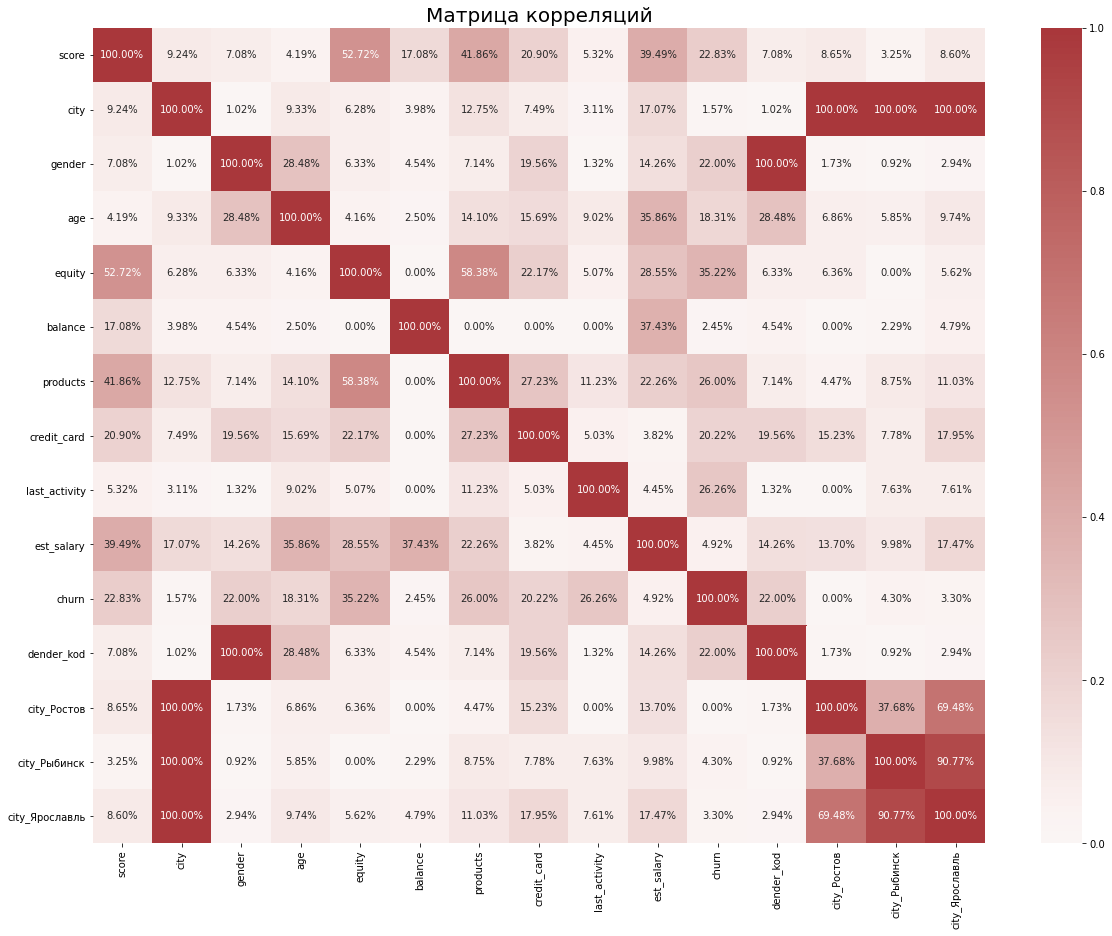

In [35]:
data = data.drop(['userid'], axis=1)
#corr_matrix = data.corr()
corr_matrix = data.phik_matrix()

plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, center=0 ,cmap="vlag", annot=True, fmt='.2%')
plt.title('Матрица корреляций', fontsize = 20)
plt.show()

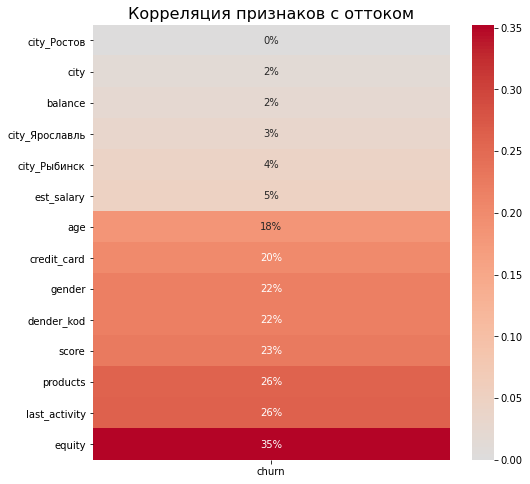

In [36]:
# построим отдельно тепловую карту корреляций признаков непосредственно с оттоком
plt.figure(figsize=(8,8))
sns.heatmap(
    corr_matrix.loc[:,['churn']].drop('churn').sort_values('churn'),
    annot=True, fmt='.0%', cmap='coolwarm', center=0
)
plt.title('Корреляция признаков с оттоком', fontsize = 16)
plt.show()

Согласно шкале Чеддока наблюдаем наличие взаимосвязи следующих показателей с вероятность оттока:<br>
- количество объектов в собственности - умеренная связь
- активность, кол-во продуктов, оценка, пол, наличие кредитки, возраст - слабая.

### Проверка статистических гипотез
#### Гипотеза о различии дохода между теми клиентами, которые ушли и теми, которые остались. 

H0: в среднем доходы отточных клиентов равны доходам клиентов, оставшихся с банком.<br>
H1: в среднем доходы отточных клиентов отличаются от доходов клиентов, оставшихся с банком.<br>

##### t-критерий Стьюдента<br>
Три аспекта, которые надо проверить, чтобы понять, можно ли применять t-тест:

- Генеральные совокупности не должны зависеть друг от друга.<br>
- Выборочные средние должны быть нормально распределены.<br>
- Дисперсии рассматриваемых генеральных совокупностей должны быть равны.

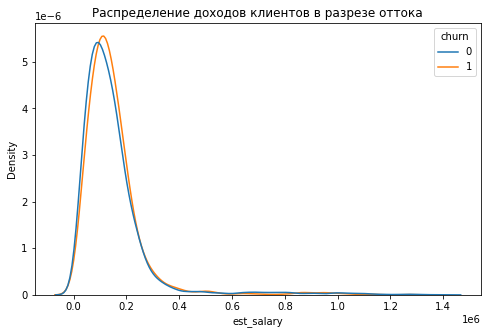

In [37]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=data, x='est_salary', hue='churn', common_norm=False);
plt.title(f'Распределение доходов клиентов в разрезе оттока')
plt.show()

In [38]:
salary_0 = data.query('churn == 0')['est_salary']
salary_1 = data.query('churn == 1')['est_salary']

print('Описание salary_0')
print(salary_0.describe().round(2))
print('---------------------')
print('Описание salary_1')
print(salary_1.describe().round(2))

Описание salary_0
count       8105.00
mean      147788.27
std       142792.18
min         2546.30
25%        73489.66
50%       118247.25
75%       174087.83
max      1395064.45
Name: est_salary, dtype: float64
---------------------
Описание salary_1
count       1818.00
mean      148357.48
std       122931.98
min        10880.27
25%        83285.66
50%       125408.88
75%       176017.84
max      1263028.49
Name: est_salary, dtype: float64


Исходя из критерие теста, относиться к результатам t-критерий Стьюдента необходиом с осторожностью:

In [39]:
alpha = 0.01

results = st.ttest_ind(salary_0, salary_1)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу, статистической разницы в доходах клиентов нет")

p-значение: 0.8749429961814755
Не получилось отвергнуть нулевую гипотезу, статистической разницы в доходах клиентов нет


##### u-критерий Манна-Уитни
Сравним выборки другим способом. Главное отличие u-критерия Манна-Уитни от t-критерия Стьюдента в том, что он работает с рангами, — номерами значений в упорядоченном ряду, — никак не учитывая сами значения. Поэтому им пользуются тогда, когда работа с самими значениями невозможна из-за выбросов, сильно сдвигающих результаты.

In [40]:
alpha = 0.01  # критический уровень статистической значимости

results = st.mannwhitneyu(salary_0, salary_1)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу, статистической разницы в доходах клиентов нет") 

p-значение:  0.00020329119363804673
Отвергаем нулевую гипотезу


В случае с доходами людей, лучше использовать u-критерий Манна-Уитни, т.к в них могут быть аномальные значения.

#### Гипотеза о равенстве количества продуктов у клиентов, которые ушли и у тех, которые остались.

H0: в среднем количество продуктов у клиентов, которые ушли, равно количеству продуктов у клиентов, оставшихся с банком.<br>

H1: в среднем количество продуктов у клиентов, которые ушли, отлично от количества продуктов у клиентов, оставшихся с банком.<br>

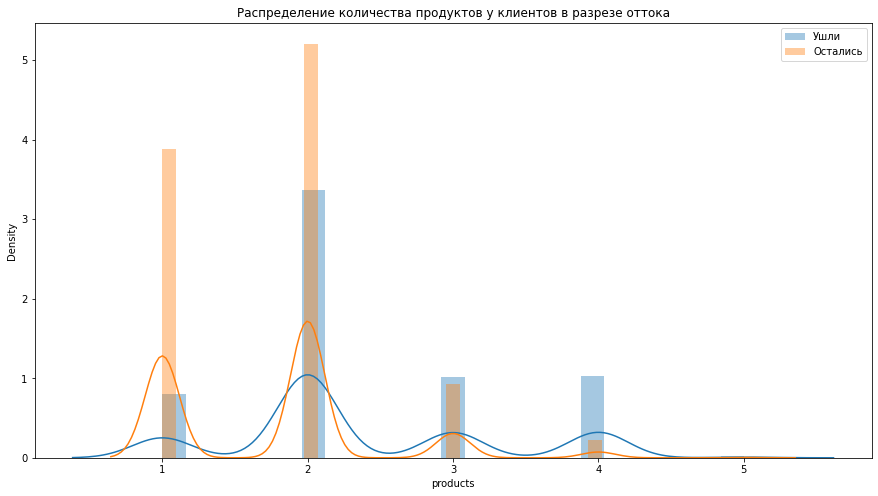

In [41]:
# создадим два датафрейма с клиентами в оттоке и оставшимися 
churn_1 = data.query('churn == 1')
churn_0 = data.query('churn == 0')
# выведем график распределения значений возраста у ушедших и оставшихся клиентов
plt.figure(figsize=(15,8))
sns.distplot(churn_1['products'],label='Ушли')
sns.distplot(churn_0['products'],label='Остались')
plt.title('Распределение количества продуктов у клиентов в разрезе оттока')
plt.legend()
plt.show()

In [42]:
# посчитаем дисперсию и средние значения возрастов клиентов в оттоке и оставшихся
prod_churn_0 = np.array(churn_0['products'])
prod_churn_1 = np.array(churn_1['products'])

print('Дисперсия кол-ва продуктов у оставшихся клиентов:', np.var(prod_churn_0))
print('Дисперсия кол-ва продуктов у ушедших клиетов:', np.var(prod_churn_1))
print()
print('Среднее кол-во продуктов у оставшихся клиентов:', np.mean(prod_churn_0))
print('Среднее кол-во пролуктов у ушедших клиетов:', np.mean(prod_churn_1))

Дисперсия кол-ва продуктов у оставшихся клиентов: 0.5089435885648
Дисперсия кол-ва продуктов у ушедших клиетов: 0.8499154645937641

Среднее кол-во продуктов у оставшихся клиентов: 1.7584207279457125
Среднее кол-во пролуктов у ушедших клиетов: 2.3773377337733774


In [43]:
# проведем t-test 
alpha = 0.01
results = st.ttest_ind(prod_churn_1, prod_churn_0, equal_var=False)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 9.413327765189615e-139
Отвергаем нулевую гипотезу


По критерию Стьюдента значение p-value меньше уровня статистической значимости. Следовательно количество продуктов у клиентов ушедших и оставшихс действительно различается, а значит нулевая гипотеза отвергается. Это так же видно на графике, чем больше у клиента продуктов, тем более он склонен к уходу из банка. 

### Итог основной части исследования (влияние параметров на отток клиентов)

Итак, по результатам исследования можно сформулировать следующие выводы о влиянии параметров на отток клиентов: <br>

- **Уровень оттока клиентов банка более 18%**

<br>
- Среди мужчин уровень оттока (>20%) выше, чем среди женщин.<br>
- Среди клиентов, у которых кредитных карт нет, из банка уходит каждый четвертый.<br>
- Среди жителей Ярославля уровень оттока выше, чем среди жителей других городов.<br>

<br>
- Согласно матрице корреляции больше всего отток коррелирует с количеством продуктов и собственностью, что также подтверждается графиками: из банка склонны ухолить клиенты с более чем тремя объектами собственности, а также пользователи нескольких продуктов (в среднем у ушедших клиентов было более двух продуктов).

<br>


<br>
- Статистические тесты показывают, что в среднем доходы отточных клиентов отличаются от доходов клиентов, оставшихся с банком.

|Показатель |Сравнение портретов/гипотезы|Корреляции|Распределения в разрезе оттока|
| :--- | :---: | :---: | :--- |
|
|user_id    |  не может быть связи |  нет связи | нет связи |
|score      |  есть связь | слабая связь   | отточный интервал с 820 по 900  |
|city       | клиенты из Ярославля | нет связи   | клиенты из Ярославля  | 
|gender     | преимущественно мужчины  |  слабая связь | преимущественно мужчины    |
|age        | нет значительного различия   | слабая связь  | отточный интервал с 26 по 35 и с 51 до 61   |
|equity     | есть различия | умеренная связь | отточный интервал с 3 включительно  |
|balance    | нет значительного различия                  |нет связи |  отточный интервал с 800 000   |
|products   | есть связь|слабая связь  | отточный интервал с 3 включительно |
|credit_card| есть связь |слабая связь | отсутствие кредитной карты |
|last_activity| есть связь |слабая связь | не активные клиенты |
|est_salary |  есть связь  |нет связи|   отточный интервал с 100 000     |
</div>

### Cегменты отточных клиентов на основе выводов о значимости критериев

Сформируем сегменты клиентов с вероятностью оттока для выбора наиболее подходящих:

In [44]:
print('Сегмент мужчины с балансом более 800 тыс ')
print('Процент оттока: {:.2%}'.format(data.query('dender_kod == 0 and balance > 800000')['churn'].mean()))
print('Размер группы:', data.query('dender_kod == 0 and balance > 800000')['churn'].count())
print('---------------------------------------')

print('Сегмент неактивные клиенты с более 4 объектами собственности')
print('Процент оттока: {:.2%}'.format(data.query('equity > 4 and last_activity == 1')['churn'].mean()))
print('Размер группы:', data.query('equity > 4 and last_activity == 1')['churn'].count())
print('---------------------------------------')

print('Сегмент клиентов с более, чем двумя продуктами')
print('Процент оттока: {:.2%}'.format(data.query('products > 2')['churn'].mean()))
print('Размер группы:', data.query('products > 2')['churn'].count())
print('---------------------------------------')

print('Сегмент мужчины без кредитных карт')
print('Процент оттока: {:.2%}'.format(data.query('dender_kod == 0 and credit_card == 0')['churn'].mean()))
print('Размер группы:', data.query('dender_kod == 0 and credit_card == 0')['churn'].count())
print('---------------------------------------')

print('Сегмент клиенты от 50 до 62 лет с оценкой по скорингу от 860 до 900')
print('Процент оттока: {:.2%}'.format(data.query('score>860 and score<900 and age>50 and age<62')['churn'].mean()))
print('Размер группы:', data.query('score>860 and score<900 and age>50 and age<62')['churn'].count())
print('---------------------------------------')


print('Сегмент молодые клиенты с доходом от 100 тыс')
print('Процент оттока: {:.2%}'.format(data.query('est_salary> 100000 and age>25 and age<36')['churn'].mean()))
print('Размер группы:', data.query('est_salary>100000 and age>25 and age<36')['churn'].count())
print('---------------------------------------')


Сегмент мужчины с балансом более 800 тыс 
Процент оттока: 45.79%
Размер группы: 1282
---------------------------------------
Сегмент неактивные клиенты с более 4 объектами собственности
Процент оттока: 43.96%
Размер группы: 1167
---------------------------------------
Сегмент клиентов с более, чем двумя продуктами
Процент оттока: 39.75%
Размер группы: 1522
---------------------------------------
Сегмент мужчины без кредитных карт
Процент оттока: 35.18%
Размер группы: 1299
---------------------------------------
Сегмент клиенты от 50 до 62 лет с оценкой по скорингу от 860 до 900
Процент оттока: 33.89%
Размер группы: 360
---------------------------------------
Сегмент молодые клиенты с доходом от 100 тыс
Процент оттока: 25.36%
Размер группы: 1514
---------------------------------------


По некоторым из выделенных сегментах отток клиентов больше чем в среднем по банку примерно в два раза. Размеры сегментов позволяют работать с клиентами без средств автоматизации (силами отдела маркетинга).

### Выводы и презентация результатов

#### Рекомендации по сегменту мужчины с балансом более 800 тыс 
Разработать специальное предложение по срочному вкладу или условиям обслуживания счета для мужчин.

#### Рекомендации по сегменту неактивные клиенты с более 4 объектами собственности
Для данного сегмента предложить особые условия страхования объектов собственности, а также рассмотреть возможность изменения условий использования такими клиентами заемных средств (при возможности объекты собственности использовать в качестве залога). Сделать рассылку о функциях мобильного приложения (*неактивные, имеется же ввиду не пользуются приложением?*)

#### Рекомендации по сегменту клиенты с более, чем двумя продуктами 
Рассмотреть возможность снижения стоимости обслуживания для клиентов с несколькоми продуктами, например, создать один продукт объединяющий несколько услуг ("пакетное предложение").